In [1]:
import importlib

packages = {
    "numpy": "numpy",
    "pandas": "pandas",
    "torch": "torch",
    "torchvision": "torchvision",
    "scikit-learn": "sklearn",
    "opencv-python": "cv2",
    "tensorboard": "tensorboard",
    "scipy": "scipy",
    "lifelines": "lifelines",
}

for pip_name, import_name in packages.items():
    try:
        mod = importlib.import_module(import_name)
        version = getattr(mod, "__version__", "no __version__ attr")
        print(f"[OK] {pip_name:15s}  (import as '{import_name}')  version: {version}")
    except ImportError:
        print(f"[MISSING] {pip_name:15s}  (import as '{import_name}')")

[OK] numpy            (import as 'numpy')  version: 1.24.1
[OK] pandas           (import as 'pandas')  version: 2.0.3
[OK] torch            (import as 'torch')  version: 2.2.0+cu118
[OK] torchvision      (import as 'torchvision')  version: 0.17.0+cu118
[OK] scikit-learn     (import as 'sklearn')  version: 1.3.2
[OK] opencv-python    (import as 'cv2')  version: 4.12.0
[OK] tensorboard      (import as 'tensorboard')  version: 2.14.0
[OK] scipy            (import as 'scipy')  version: 1.10.1
[OK] lifelines        (import as 'lifelines')  version: 0.27.8


In [19]:
import os, glob, re, pickle
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter


#### Part 1: some simple check, plots not use in the report 

In [150]:
splits_pkl = "./data/TCGA_GBMLGG/splits/gbmlgg15cv_all_st_patches_512_0_0_1_compass.pkl"
ckpt_dir   = "./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion"

print("CWD:", os.getcwd())
print("ckpt_dir exists?", os.path.exists(ckpt_dir))


CWD: /orcd/home/002/taiqili/PathomicFusion
ckpt_dir exists? True


In [151]:
all_pred_files = sorted(
    glob.glob(os.path.join(ckpt_dir, "pathomic_fusion_*_patch_pred_test.pkl"))
)
print("Found prediction files:")
for f in all_pred_files:
    print("  ", os.path.basename(f))

folds_available = []
for f in all_pred_files:
    m = re.search(r"pathomic_fusion_(\d+)_patch_pred_test\.pkl", os.path.basename(f))
    if m:
        folds_available.append(int(m.group(1)))

folds_available = sorted(set(folds_available))
print("Folds with valid pred_test files:", folds_available)


Found prediction files:
   pathomic_fusion_10_patch_pred_test.pkl
   pathomic_fusion_11_patch_pred_test.pkl
   pathomic_fusion_12_patch_pred_test.pkl
   pathomic_fusion_13_patch_pred_test.pkl
   pathomic_fusion_14_patch_pred_test.pkl
   pathomic_fusion_15_patch_pred_test.pkl
   pathomic_fusion_1_patch_pred_test.pkl
   pathomic_fusion_2_patch_pred_test.pkl
   pathomic_fusion_3_patch_pred_test.pkl
   pathomic_fusion_4_patch_pred_test.pkl
   pathomic_fusion_5_patch_pred_test.pkl
   pathomic_fusion_6_patch_pred_test.pkl
   pathomic_fusion_7_patch_pred_test.pkl
   pathomic_fusion_8_patch_pred_test.pkl
   pathomic_fusion_9_patch_pred_test.pkl
Folds with valid pred_test files: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [152]:
with open(splits_pkl, "rb") as f:
    splits_data = pickle.load(f)

cv_splits = splits_data["cv_splits"]
print("cv_splits keys:", cv_splits.keys())


cv_splits keys: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


In [153]:
def load_fold_patches_k(k, ckpt_dir, model_name="pathomic_fusion"):
    """
    Load patch-level predictions for fold k.
    Returns a DataFrame with columns:
      ['risk', 'survtime', 'censor', 'fold']
    """
    pred_file = os.path.join(
        ckpt_dir,
        f"{model_name}_{k}_patch_pred_test.pkl"
    )
    print(f"[Fold {k}] Loading predictions from {pred_file}")
    risk_pred_all, survtime_all, censor_all, probs_all, gt_all = pickle.load(
        open(pred_file, "rb")
    )

    df = pd.DataFrame({
        "risk":      np.array(risk_pred_all, dtype=float),
        "survtime":  np.array(survtime_all, dtype=float),
        "censor":    np.array(censor_all, dtype=float),
        "fold":      k
    })
    return df


In [154]:
all_patches = []
fold_cindices = []

for k in folds_available:
    df_patch = load_fold_patches_k(k, ckpt_dir, model_name="pathomic_fusion")
    all_patches.append(df_patch)

    cindex = concordance_index(
        df_patch["survtime"].values,
        -df_patch["risk"].values,
        df_patch["censor"].values,
    )
    fold_cindices.append({"fold": k, "cindex": cindex})

df_all_patches = pd.concat(all_patches, ignore_index=True)
df_cindex = pd.DataFrame(fold_cindices).sort_values("fold")

print(df_cindex)
print(
    "Patch-level mean C-index: %.4f ± %.4f"
    % (df_cindex["cindex"].mean(), df_cindex["cindex"].std())
)


[Fold 1] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_1_patch_pred_test.pkl
[Fold 2] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_2_patch_pred_test.pkl
[Fold 3] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_3_patch_pred_test.pkl
[Fold 4] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_4_patch_pred_test.pkl
[Fold 5] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_5_patch_pred_test.pkl
[Fold 6] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_6_patch_pred_test.pkl
[Fold 7] Loading predictions from ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_7_patch_pred_test.pkl
[Fold 8] Load

In [15]:
df_cindex

,fold,cindex
0,1,0.793779
1,2,0.695763
2,3,0.626673
3,4,0.790800
4,5,0.776400
5,6,0.790295
6,7,0.848714
7,8,0.825109
8,9,0.836444
9,10,0.755557


In [103]:
df_all_patches

,risk,survtime,censor,fold
0,2.669885,313.0,1.0,1
1,2.761713,313.0,1.0,1
2,2.218584,313.0,1.0,1
3,2.755001,313.0,1.0,1
4,2.724126,313.0,1.0,1
...,...,...,...,...
24430,-1.424354,1127.0,0.0,15
24431,-1.555529,1127.0,0.0,15
24432,-1.753075,1127.0,0.0,15
24433,-2.691153,1127.0,0.0,15


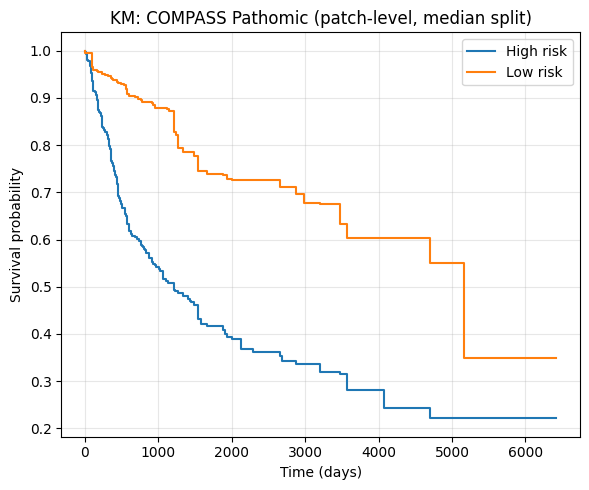

In [115]:
#not in use , patch level KM 
def plot_km_median_split_patch(df_patch, title="KM: COMPASS Pathomic (patch-level, median split)"):
    median_risk = df_patch["risk"].median()
    df = df_patch.copy()
    df["risk_group"] = np.where(
        df["risk"] >= median_risk, "High risk", "Low risk"
    )

    kmf = KaplanMeierFitter()
    plt.figure(figsize=(6, 5))
    for group_name, df_group in df.groupby("risk_group"):
        kmf.fit(
            durations=df_group["survtime"],
            event_observed=df_group["censor"],
            label=group_name,
        )
        kmf.plot(ci_show=False)

    plt.title(title)
    plt.xlabel("Time (days)")
    plt.ylabel("Survival probability")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_km_median_split_patch(df_all_patches)


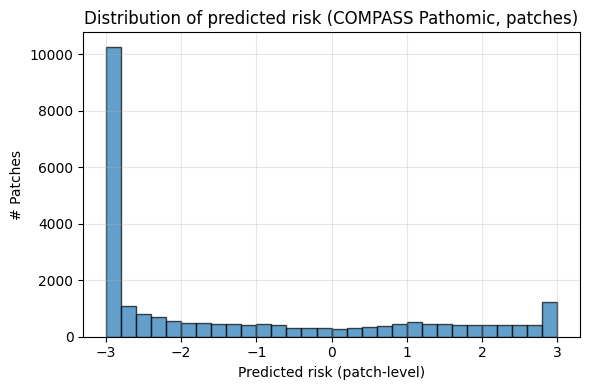

In [17]:
plt.figure(figsize=(6, 4))
plt.hist(df_all_patches["risk"], bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Predicted risk (patch-level)")
plt.ylabel("# Patches")
plt.title("Distribution of predicted risk (COMPASS Pathomic, patches)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 600x400 with 0 Axes>

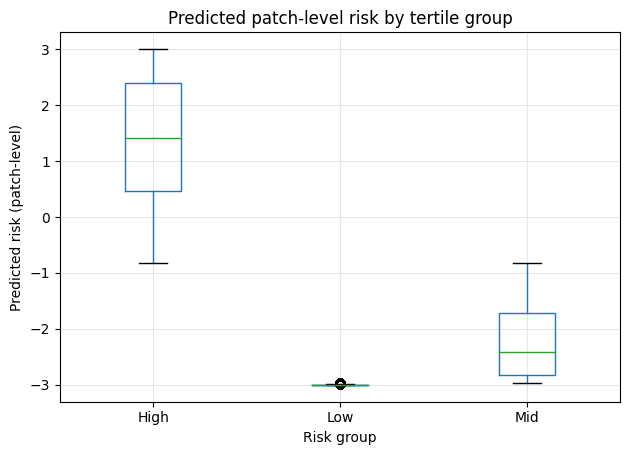

In [18]:
def add_risk_tertiles_patch(df_patch):
    df = df_patch.copy()
    q33 = df["risk"].quantile(0.33)
    q66 = df["risk"].quantile(0.66)

    def assign_group(r):
        if r <= q33:
            return "Low"
        elif r <= q66:
            return "Mid"
        else:
            return "High"

    df["risk_tertile"] = df["risk"].apply(assign_group)
    return df

df_patch_tertiles = add_risk_tertiles_patch(df_all_patches)

plt.figure(figsize=(6, 4))
df_patch_tertiles.boxplot(column="risk", by="risk_tertile")
plt.title("Predicted patch-level risk by tertile group")
plt.suptitle("")
plt.xlabel("Risk group")
plt.ylabel("Predicted risk (patch-level)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


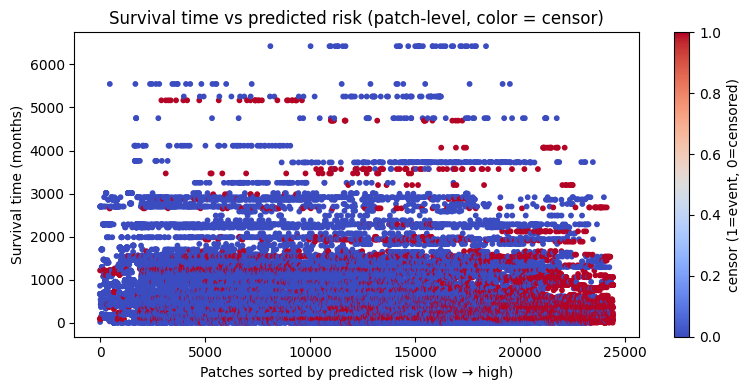

In [19]:
df_sorted = df_all_patches.sort_values("risk").reset_index(drop=True)

plt.figure(figsize=(8, 4))
sc = plt.scatter(
    np.arange(len(df_sorted)),
    df_sorted["survtime"],
    c=df_sorted["censor"],
    cmap="coolwarm",
    s=10,
)
plt.xlabel("Patches sorted by predicted risk (low → high)")
plt.ylabel("Survival time (months)")
plt.title("Survival time vs predicted risk (patch-level, color = censor)")
plt.colorbar(sc, label="censor (1=event, 0=censored)")
plt.tight_layout()
plt.show()


In [26]:

ckpt_path = "./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/"


gate_files = sorted(glob.glob(os.path.join(ckpt_path, "*_gate_test.pkl")))
print("Found gate files:", len(gate_files))
print("\n".join(gate_files[:5]))


Found gate files: 30
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_10_patch_1_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_10_patch_2_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_11_patch_1_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_11_patch_2_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi/pathomic_fusion/pathomic_fusion_12_patch_1_gate_test.pkl


In [27]:
def parse_fold_epoch(fname):
 
    base = os.path.basename(fname)
    m = re.match(r"pathomic_fusion_(\d+)_patch_(\d+)_gate_test\.pkl", base)
    if m is None:
        raise ValueError(f"Filename not recognized: {base}")
    fold = int(m.group(1))
    epoch = int(m.group(2))
    return fold, epoch


In [28]:
all_gates = []
all_risk = []
all_time = []
all_censor = []

for gate_f in gate_files:
    fold, epoch = parse_fold_epoch(gate_f)


    pred_f = os.path.join(
        ckpt_path,
        f"pathomic_fusion_{fold}_patch_{epoch}_pred_test.pkl"
    )
    if not os.path.exists(pred_f):
        print(f"[WARN] pred_test file not found for gate: {gate_f}")
        continue


    gates = pickle.load(open(gate_f, "rb"))
    gates = np.asarray(gates)        # shape: (N, 32)


    pred_obj = pickle.load(open(pred_f, "rb"))
   
    risk_pred_all = np.asarray(pred_obj[0])
    survtime_all  = np.asarray(pred_obj[1])
    censor_all    = np.asarray(pred_obj[2])


    if gates.shape[0] != risk_pred_all.shape[0]:
        print(f"[WARN] size mismatch in {gate_f}: gates={gates.shape[0]}, risk={risk_pred_all.shape[0]}")
        continue

    all_gates.append(gates)
    all_risk.append(risk_pred_all)
    all_time.append(survtime_all)
    all_censor.append(censor_all)


all_gates = np.concatenate(all_gates, axis=0)
all_risk  = np.concatenate(all_risk, axis=0)
all_time  = np.concatenate(all_time, axis=0)
all_censor= np.concatenate(all_censor, axis=0)

print("=== Loaded combined arrays ===")
print("gates :", all_gates.shape)   # (N_total, 32)
print("risk  :", all_risk.shape)
print("time  :", all_time.shape)
print("censor:", all_censor.shape)
print("Example gate vector:", all_gates[0])
print("Example risk value:", all_risk[0])


=== Loaded combined arrays ===
gates : (48870, 32)
risk  : (48870,)
time  : (48870,)
censor: (48870,)
Example gate vector: [0.5557589  0.41922516 0.09559851 0.805985   0.3414513  0.18426792
 0.56482995 0.05760174 0.40759292 0.5497776  0.6390495  0.88292575
 0.40620187 0.85500604 0.41593853 0.7656902  0.4476657  0.4430836
 0.5508044  0.57138526 0.92824    0.73536396 0.4270459  0.61267483
 0.96418464 0.60691565 0.4633495  0.1429141  0.50667477 0.52120316
 0.4614768  0.8797418 ]
Example risk value: 3.0


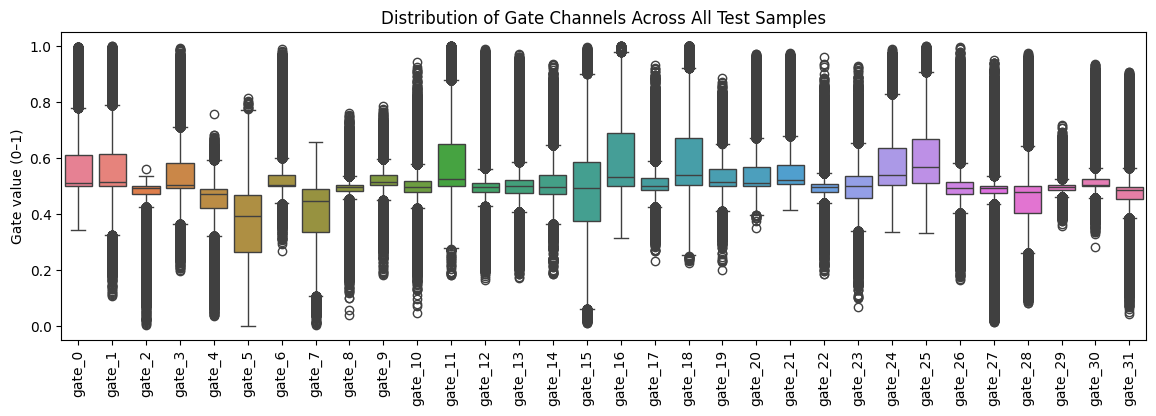

In [29]:
df_gate = pd.DataFrame(all_gates, columns=[f"gate_{i}" for i in range(all_gates.shape[1])])

plt.figure(figsize=(14,4))
sns.boxplot(data=df_gate)
plt.xticks(rotation=90)
plt.title("Distribution of Gate Channels Across All Test Samples")
plt.ylabel("Gate value (0–1)")
plt.show()


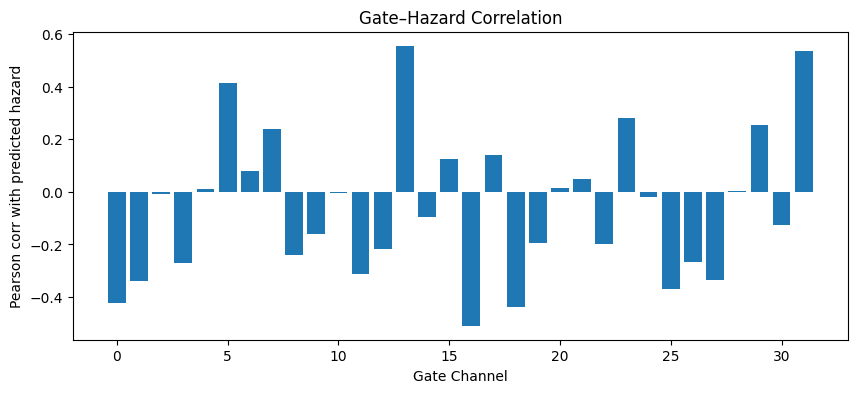

Top 5 most correlated gate channels:
gate_13: corr = 0.556
gate_31: corr = 0.536
gate_16: corr = -0.509
gate_18: corr = -0.440
gate_0: corr = -0.424


In [30]:
cors = []
for i in range(all_gates.shape[1]):
    corr = np.corrcoef(all_gates[:, i], all_risk)[0, 1]
    cors.append(corr)

plt.figure(figsize=(10,4))
plt.bar(range(len(cors)), cors)
plt.xlabel("Gate Channel")
plt.ylabel("Pearson corr with predicted hazard")
plt.title("Gate–Hazard Correlation")
plt.show()

order = np.argsort(np.abs(cors))[::-1]
print("Top 5 most correlated gate channels:")
for idx in order[:5]:
    print(f"gate_{idx}: corr = {cors[idx]:.3f}")


In [31]:
all_gates.shape

(48870, 32)

#### Part 2: plots use in the report 

In [70]:


split_pkl = "./data/TCGA_GBMLGG/splits/gbmlgg15cv_all_st_patches_512_0_0_1_compass.pkl"
data = pickle.load(open(split_pkl, "rb"))

print(data.keys())  

cv_splits = data["cv_splits"]
print(type(cv_splits), cv_splits.keys())   

fold = list(cv_splits.keys())[0]



dict_keys(['data_pd', 'pat2img', 'img_fnames', 'cv_splits'])
<class 'dict'> dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


In [9]:


def get_test_patnames_for_fold(cv_splits, fold):
    """

    """  
    keys = list(cv_splits.keys())
    if fold in cv_splits:
        fold_key = fold
    elif str(fold) in cv_splits:
        fold_key = str(fold)
    elif int(fold) in cv_splits:
        fold_key = int(fold)
    else:
        raise KeyError(f"Fold {fold} not found in cv_splits keys: {keys}")

    test_info = cv_splits[fold_key]['test']
    x_patname = np.array(test_info['x_patname'])   # 每个 patch 对应一个病人名
    return x_patname


In [10]:
x_patname_example = get_test_patnames_for_fold(cv_splits, 5)
print(x_patname_example.shape)
print(x_patname_example[:5])

(1719,)
['TCGA-06-0130' 'TCGA-06-0130' 'TCGA-06-0130' 'TCGA-06-0130'
 'TCGA-06-0130']


In [11]:

ckpt_dir = "./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/"
gate_files = sorted(glob.glob(os.path.join(ckpt_dir, "*_gate_test.pkl")))
print("Found gate files:", len(gate_files))
print("\n".join(gate_files[:5]))


Found gate files: 150
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_10_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_1_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_2_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_3_gate_test.pkl
./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_4_gate_test.pkl


In [12]:
def parse_fold_epoch_from_gate(fname):
  
 
    base = os.path.basename(fname)
    m = re.match(r"pathomic_fusion_(\d+)_patch_(\d+)_gate_test\.pkl", base)
    if m is None:
        raise ValueError(f"Filename pattern not recognized: {base}")
    fold = int(m.group(1))
    epoch = int(m.group(2))
    return fold, epoch


In [13]:

# map from patches level to patient level 
all_patient_rows = []  

for gate_f in gate_files:
    fold, epoch = parse_fold_epoch_from_gate(gate_f)
    print(f"Processing gate file: {gate_f}, fold={fold}, epoch={epoch}")

    
    gates_fold = np.asarray(pickle.load(open(gate_f, "rb"))) 

   
    pred_f = os.path.join(ckpt_dir, f"pathomic_fusion_{fold}_patch_{epoch}_pred_test.pkl")
    if not os.path.exists(pred_f):
        print(f"  [WARN] pred file missing for {gate_f}, skip")
        continue

    pred_obj = pickle.load(open(pred_f, "rb"))
    
    risk_fold = np.asarray(pred_obj[0])
    time_fold = np.asarray(pred_obj[1])
    censor_fold = np.asarray(pred_obj[2])


    x_patname = get_test_patnames_for_fold(cv_splits, fold)   
    

    if len(x_patname) != gates_fold.shape[0] or len(x_patname) != risk_fold.shape[0]:
        print(f"  [WARN] length mismatch: patname={len(x_patname)}, gates={gates_fold.shape[0]}, risk={risk_fold.shape[0]}")
        continue
    

    df_patch = pd.DataFrame({
        "fold": fold,
        "epoch": epoch,
        "patient_id": x_patname,
        "risk": risk_fold,
        "time": time_fold,
        "censor": censor_fold,
    })
    for i in range(gates_fold.shape[1]):
        df_patch[f"gate_{i}"] = gates_fold[:, i]

    
    agg_dict = {
        "risk": "mean",
        "time": "first",
        "censor": "first",
    }
    for i in range(gates_fold.shape[1]):
        agg_dict[f"gate_{i}"] = "mean"   

    df_patient = df_patch.groupby("patient_id").agg(agg_dict).reset_index()
    df_patient["fold"] = fold
    df_patient["epoch"] = epoch

    all_patient_rows.append(df_patient)


df_all_patients = pd.concat(all_patient_rows, axis=0, ignore_index=True)
print("df_all_patients shape:", df_all_patients.shape)
df_all_patients.head()


Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_10_gate_test.pkl, fold=10, epoch=10
Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_1_gate_test.pkl, fold=10, epoch=1
Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_2_gate_test.pkl, fold=10, epoch=2
Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_3_gate_test.pkl, fold=10, epoch=3
Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_4_gate_test.pkl, fold=10, epoch=4
Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pathomic_fusion/pathomic_fusion_10_patch_5_gate_test.pkl, fold=10, epoch=5
Processing gate file: ./checkpoints/TCGA_GBMLGG/surv_compass_omic_gates_bi_ff/pa

,patient_id,risk,time,censor,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,...,gate_24,gate_25,gate_26,gate_27,gate_28,gate_29,gate_30,gate_31,fold,epoch
0,TCGA-06-0156,2.999981,178.0,1.0,0.5,0.5,0.224783,0.471351,0.5,0.611919,...,0.844842,0.5,0.5,0.284442,0.5,0.5,0.5,0.816405,10,10
1,TCGA-06-0158,2.995069,329.0,1.0,0.5,0.5,0.249547,0.479449,0.5,0.567407,...,0.807186,0.5,0.5,0.352108,0.5,0.5,0.5,0.709690,10,10
2,TCGA-06-0190,2.998806,317.0,1.0,0.5,0.5,0.446349,0.494686,0.5,0.561344,...,0.761202,0.5,0.5,0.322087,0.5,0.5,0.5,0.736623,10,10
3,TCGA-06-0644,3.000000,384.0,1.0,0.5,0.5,0.242747,0.485798,0.5,0.587161,...,0.891323,0.5,0.5,0.262828,0.5,0.5,0.5,0.807880,10,10
4,TCGA-06-0686,2.801100,432.0,1.0,0.5,0.5,0.532497,0.498848,0.5,0.527809,...,0.666672,0.5,0.5,0.399999,0.5,0.5,0.5,0.666477,10,10


In [14]:
len(df_all_patients['patient_id'].unique())

457

In [15]:
#patients level dataset 

df = df_all_patients.copy()

print("Total rows:", df.shape[0])
print("Unique patients:", df["patient_id"].nunique())


check = df.groupby("patient_id")[["time", "censor"]].nunique()
print(check.head())



agg_dict = {
    "risk": "mean",
    "time": "first",
    "censor": "first",
}
gate_cols = [c for c in df.columns if c.startswith("gate_")]
for g in gate_cols:
    agg_dict[g] = "mean"  

df_patient_final = df.groupby("patient_id").agg(agg_dict).reset_index()

print("After collapsing per patient:")
print(df_patient_final.shape)     
df_patient_final.head()


Total rows: 14010
Unique patients: 457
              time  censor
patient_id                
TCGA-06-0125     1       1
TCGA-06-0129     1       1
TCGA-06-0130     1       1
TCGA-06-0138     1       1
TCGA-06-0141     1       1
After collapsing per patient:
(457, 36)


,patient_id,risk,time,censor,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,...,gate_22,gate_23,gate_24,gate_25,gate_26,gate_27,gate_28,gate_29,gate_30,gate_31
0,TCGA-06-0125,2.692275,1448.0,1.0,0.495315,0.493830,0.500166,0.591093,0.433275,0.390575,...,0.492722,0.671014,0.702154,0.618236,0.342579,0.129594,0.152962,0.486722,0.768803,0.507655
1,TCGA-06-0129,1.081837,1024.0,1.0,0.523708,0.525204,0.498294,0.532797,0.431806,0.371275,...,0.432411,0.555753,0.604532,0.557718,0.467144,0.395409,0.416514,0.496293,0.576695,0.505292
2,TCGA-06-0130,0.967569,394.0,1.0,0.463555,0.595097,0.502029,0.572410,0.496213,0.412901,...,0.451467,0.657187,0.604742,0.551263,0.337864,0.271617,0.278938,0.492362,0.682725,0.503708
3,TCGA-06-0138,1.483634,737.0,1.0,0.506022,0.524540,0.497201,0.609354,0.531016,0.411617,...,0.378972,0.497870,0.501647,0.637350,0.570122,0.498751,0.463758,0.500440,0.497663,0.501960
4,TCGA-06-0141,2.171426,313.0,1.0,0.498133,0.460917,0.379953,0.318815,0.441756,0.376734,...,0.505488,0.499065,0.769975,0.506253,0.495494,0.492936,0.469250,0.505249,0.499938,0.501205


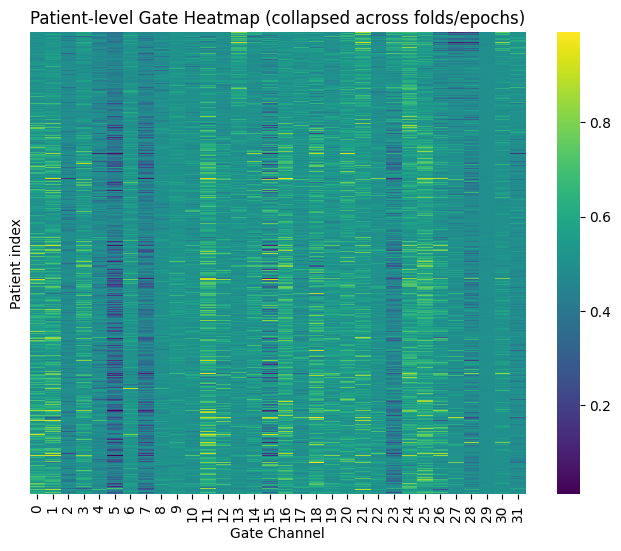

In [40]:


gate_mat = df_patient_final[gate_cols].values  

plt.figure(figsize=(8, 6))
sns.heatmap(gate_mat, cmap="viridis", cbar=True, yticklabels=False)
plt.title("Patient-level Gate Heatmap (collapsed across folds/epochs)")
plt.xlabel("Gate Channel")
plt.ylabel("Patient index")
plt.show()


In [16]:
from scipy.stats import spearmanr

cors = []
rhos = []
for g in gate_cols:
    rho, pval = spearmanr(df_patient_final[g], df_patient_final["risk"])
    cors.append((g, rho, pval))
    rhos += [rho]

cors_sorted = sorted(cors, key=lambda x: abs(x[1]), reverse=True)
print("Top correlated gates with risk:")
for g, rho, p in cors_sorted[:5]:
    print(f"{g}: Spearman ρ = {rho:.3f}, p = {p:.2e}")


Top correlated gates with risk:
gate_31: Spearman ρ = 0.640, p = 5.26e-54
gate_23: Spearman ρ = 0.626, p = 3.49e-51
gate_13: Spearman ρ = 0.509, p = 1.60e-31
gate_16: Spearman ρ = -0.506, p = 3.79e-31
gate_26: Spearman ρ = -0.480, p = 1.14e-27


In [17]:
rhos

[-0.46094210088779625,
 -0.43185512322175496,
 0.020753422211851,
 -0.3569284356774041,
 -0.0835591003250341,
 0.43916373760502764,
 -0.22090774172490849,
 0.4416546763313548,
 -0.34955720835824866,
 -0.2681074598912597,
 -0.10709288893068675,
 -0.4742533847446726,
 -0.34834191390394426,
 0.5092327677381946,
 -0.33261174437036,
 0.06663537696256351,
 -0.5064829534396128,
 0.1819896530237522,
 -0.38072977514160844,
 -0.3347509568825372,
 -0.09348576523820326,
 -0.06267328570056334,
 -0.34682663056406465,
 0.626443177880585,
 -0.010947331205331708,
 -0.46369795016814974,
 -0.47966600902129203,
 -0.22751473376409917,
 0.09445651720196119,
 0.11623739506046803,
 -0.130429790355728,
 0.6399048333666096]

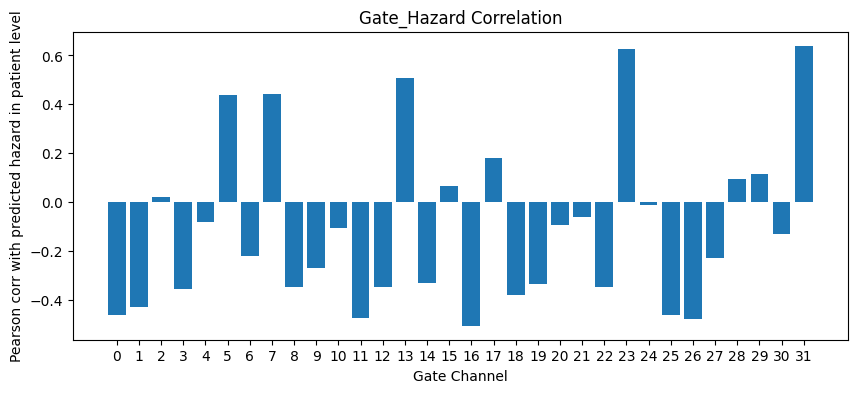

Top 5 most correlated gate channels:
gate_31: corr = 0.640
gate_23: corr = 0.626
gate_13: corr = 0.509
gate_16: corr = -0.506
gate_26: corr = -0.480


In [69]:
# corr with hazrad and gates
plt.figure(figsize=(10,4))
plt.bar(range(len(rhos)), rhos)
plt.xticks(np.arange(32))
plt.xlabel("Gate Channel")
plt.ylabel("Pearson corr with predicted hazard in patient level")
plt.title("Gate_Hazard Correlation")
plt.show()

order = np.argsort(np.abs(rhos))[::-1]
print("Top 5 most correlated gate channels:")
for idx in order[:5]:
    print(f"gate_{idx}: corr = {rhos[idx]:.3f}")


In [21]:
df_patient_final.iloc[:,-1]

0      0.507655
1      0.505292
2      0.503708
3      0.501960
4      0.501205
         ...   
452    0.493390
453    0.498423
454    0.495948
455    0.488797
456    0.498377
Name: gate_31, Length: 457, dtype: float32

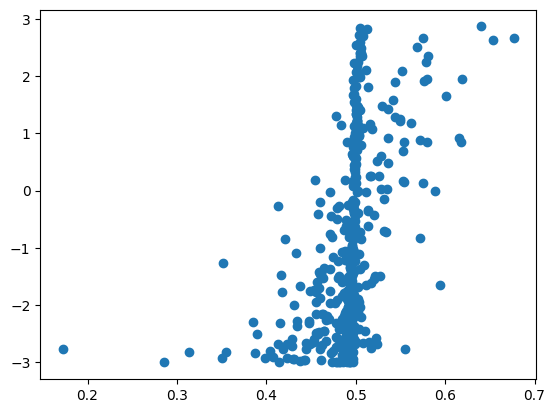

In [23]:
plt.scatter(df_patient_final.iloc[:,-1], df_patient_final['risk'])

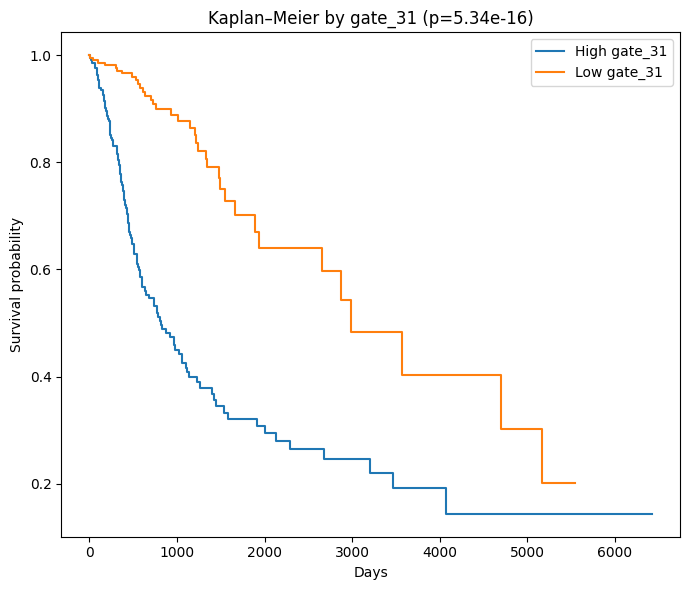

In [24]:
#km for gate 31
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt


gate_31_values  = df_patient_final["gate_31"]
survival_time   = df_patient_final['time']
censor          = df_patient_final['censor']

gate_id = 31   # gate_31
gate_name = f"gate_{gate_id}"

gate_vals = df_patient_final[gate_name]


threshold = gate_vals.median()
high_idx = gate_vals >= threshold
low_idx  = gate_vals < threshold


T_high = survival_time[high_idx]
E_high = censor[high_idx]

T_low  = survival_time[low_idx]
E_low  = censor[low_idx]


kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

plt.figure(figsize=(7,6))

kmf_high.fit(T_high, event_observed=E_high, label=f"High {gate_name}")
kmf_high.plot(ci_show=False)

kmf_low.fit(T_low, event_observed=E_low, label=f"Low {gate_name}")
kmf_low.plot(ci_show=False)


results = logrank_test(T_high, T_low, event_observed_A=E_high, event_observed_B=E_low)
pval = results.p_value

high_index_31 = high_idx
plt.title(f"Kaplan–Meier by {gate_name} (p={pval:.2e})")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.grid(False)
plt.tight_layout()
plt.show()


In [26]:
df_patient_final

,patient_id,risk,time,censor,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,...,gate_22,gate_23,gate_24,gate_25,gate_26,gate_27,gate_28,gate_29,gate_30,gate_31
0,TCGA-06-0125,2.692275,1448.0,1.0,0.495315,0.493830,0.500166,0.591093,0.433275,0.390575,...,0.492722,0.671014,0.702154,0.618236,0.342579,0.129594,0.152962,0.486722,0.768803,0.507655
1,TCGA-06-0129,1.081837,1024.0,1.0,0.523708,0.525204,0.498294,0.532797,0.431806,0.371275,...,0.432411,0.555753,0.604532,0.557718,0.467144,0.395409,0.416514,0.496293,0.576695,0.505292
2,TCGA-06-0130,0.967569,394.0,1.0,0.463555,0.595097,0.502029,0.572410,0.496213,0.412901,...,0.451467,0.657187,0.604742,0.551263,0.337864,0.271617,0.278938,0.492362,0.682725,0.503708
3,TCGA-06-0138,1.483634,737.0,1.0,0.506022,0.524540,0.497201,0.609354,0.531016,0.411617,...,0.378972,0.497870,0.501647,0.637350,0.570122,0.498751,0.463758,0.500440,0.497663,0.501960
4,TCGA-06-0141,2.171426,313.0,1.0,0.498133,0.460917,0.379953,0.318815,0.441756,0.376734,...,0.505488,0.499065,0.769975,0.506253,0.495494,0.492936,0.469250,0.505249,0.499938,0.501205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,TCGA-VM-A8CE,-2.563960,1191.0,0.0,0.740907,0.871887,0.496162,0.493379,0.670875,0.476916,...,0.564334,0.399176,0.499159,0.511913,0.252714,0.494883,0.606994,0.496599,0.508252,0.493390
453,TCGA-VV-A829,-0.785808,1127.0,0.0,0.531393,0.528280,0.498332,0.509663,0.496633,0.428000,...,0.491713,0.506459,0.543482,0.543217,0.506787,0.496828,0.484410,0.498757,0.498391,0.498423
454,TCGA-VV-A86M,-0.827852,487.0,0.0,0.626086,0.563663,0.446752,0.506144,0.471628,0.389043,...,0.481669,0.387893,0.570269,0.632174,0.533133,0.497414,0.466008,0.499661,0.500420,0.495948
455,TCGA-W9-A837,-2.626641,1553.0,0.0,0.564577,0.745267,0.429099,0.576843,0.477825,0.292658,...,0.538080,0.274299,0.647483,0.715462,0.705743,0.492817,0.592708,0.497632,0.568577,0.488797


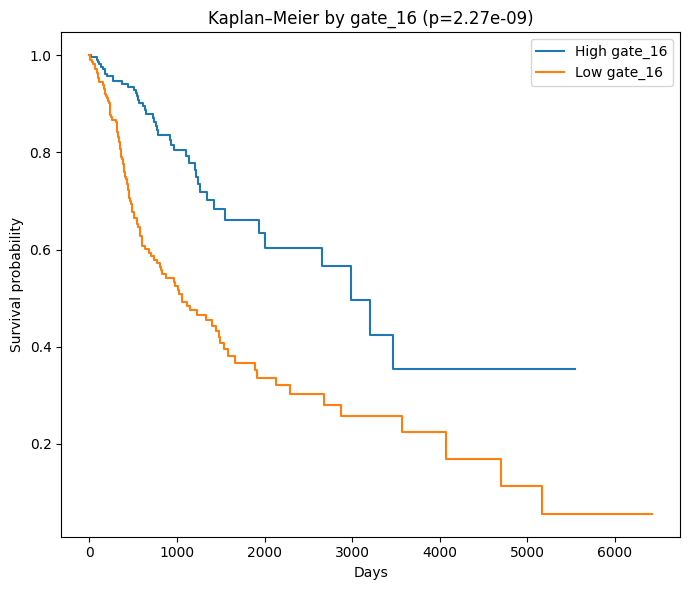

In [28]:
#KM for gate 16

gate_31_values  = df_patient_final["gate_16"]
survival_time   = df_patient_final['time']
censor          = df_patient_final['censor']

gate_id = 16   # gate_31
gate_name = f"gate_{gate_id}"

gate_vals = df_patient_final[gate_name]


threshold = gate_vals.median()
high_idx = gate_vals >= threshold
low_idx  = gate_vals < threshold


T_high = survival_time[high_idx]
E_high = censor[high_idx]

T_low  = survival_time[low_idx]
E_low  = censor[low_idx]


kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

plt.figure(figsize=(7,6))

kmf_high.fit(T_high, event_observed=E_high, label=f"High {gate_name}")
kmf_high.plot(ci_show=False)

kmf_low.fit(T_low, event_observed=E_low, label=f"Low {gate_name}")
kmf_low.plot(ci_show=False)


results = logrank_test(T_high, T_low, event_observed_A=E_high, event_observed_B=E_low)
pval = results.p_value

high_index_18 = high_idx
plt.title(f"Kaplan–Meier by {gate_name} (p={pval:.2e})")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.grid(False)
plt.tight_layout()
plt.show()


In [32]:
import seaborn as sns

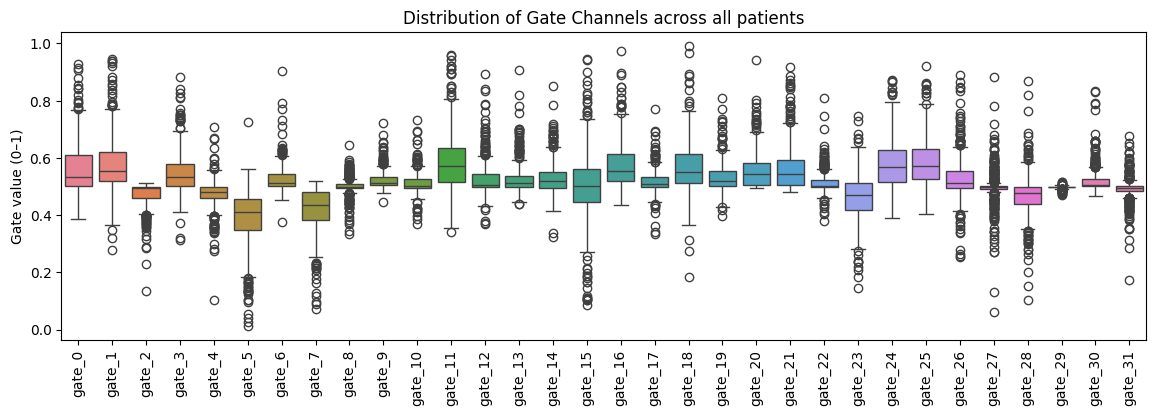

In [33]:


plt.figure(figsize=(14,4))
sns.boxplot(data=df_patient_final.iloc[:,4:])
plt.xticks(rotation=90)
plt.title("Distribution of Gate Channels across all patients")
plt.ylabel("Gate value (0–1)")
plt.show()

In [36]:
compass_embedding = pd.read_csv('data/TCGA_GBMLGG/compass_GMBLGG.csv')

In [37]:
compass_embedding = compass_embedding.drop(columns = ['Unnamed: 0']).rename(columns = {'TCGA ID':'patient_id'})
compass_embedding 

,patient_id,channel_0_Adipocyte,channel_0_Apoptosis_pathway,channel_0_Bcell_general,channel_0_CD4_Tcell,channel_0_CD8_Tcell,channel_0_Cell_proliferation,channel_0_Cytokine,channel_0_Cytotoxic_Tcell,channel_0_Endothelial,...,channel_31_Pneumocyte,channel_31_Reference,channel_31_Stem,channel_31_Stroma,channel_31_TGFb_pathway,channel_31_TLS,channel_31_Tcell_general,channel_31_Treg,channel_31_cDC,channel_31_pDC
0,TCGA-02-0047-01,-0.322608,0.170453,-0.234859,0.158943,-0.154079,-0.017478,-0.147537,-0.511682,0.042591,...,0.433528,0.561714,0.576824,0.556324,0.392157,0.337065,0.461576,0.405386,0.442246,0.431302
1,TCGA-02-0055-01,-0.294127,0.165628,-0.219759,0.185572,-0.190853,-0.012449,-0.201293,-0.557561,0.039630,...,0.427954,0.564589,0.589285,0.539796,0.386710,0.370380,0.535590,0.424185,0.466738,0.402717
2,TCGA-02-2483-01,-0.536393,0.143004,-0.260655,0.173890,-0.163120,-0.027644,-0.139995,-0.553591,0.053064,...,0.418644,0.563715,0.577793,0.547157,0.385632,0.346035,0.527583,0.408983,0.426437,0.405131
3,TCGA-02-2485-01,-0.407149,0.149409,-0.232944,0.177697,-0.169028,-0.022453,-0.178210,-0.563653,0.028707,...,0.423332,0.559860,0.583623,0.542544,0.390032,0.348628,0.547632,0.414760,0.409255,0.421322
4,TCGA-02-2486-01,-0.270806,0.207635,-0.161484,0.212598,-0.164095,-0.006455,-0.162143,-0.549624,0.026910,...,0.416685,0.562442,0.595451,0.526189,0.386933,0.374744,0.565923,0.451615,0.461323,0.428712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,TCGA-WY-A85A-01,-0.577474,0.207591,-0.243449,0.134327,-0.137483,-0.012503,-0.188835,-0.555283,0.051476,...,0.421614,0.560558,0.578368,0.547320,0.390637,0.346184,0.439423,0.412829,0.384580,0.433040
698,TCGA-WY-A85B-01,-0.371884,0.279673,-0.239900,0.190424,-0.162065,-0.029132,-0.177666,-0.517280,0.050190,...,0.425940,0.561840,0.578161,0.550392,0.387111,0.353264,0.505957,0.403293,0.374367,0.437514
699,TCGA-WY-A85C-01,-0.576137,0.242142,-0.288555,0.144890,-0.129615,-0.011543,-0.197687,-0.524599,0.046771,...,0.418597,0.552283,0.574522,0.548075,0.379073,0.345268,0.428008,0.393808,0.372578,0.432156
700,TCGA-WY-A85D-01,-0.572828,0.203070,-0.221047,0.106656,-0.130504,-0.007022,-0.171706,-0.523914,0.045206,...,0.410309,0.561822,0.574943,0.544453,0.378626,0.357729,0.447545,0.413103,0.365546,0.438998


In [39]:
df_patient_final_process = df_patient_final.copy().set_index('patient_id').drop(columns = ['risk','time','censor'])

In [40]:
compass_embedding["patient_id"] = compass_embedding["patient_id"].str.slice(0, 12)
compass_embedding

,patient_id,channel_0_Adipocyte,channel_0_Apoptosis_pathway,channel_0_Bcell_general,channel_0_CD4_Tcell,channel_0_CD8_Tcell,channel_0_Cell_proliferation,channel_0_Cytokine,channel_0_Cytotoxic_Tcell,channel_0_Endothelial,...,channel_31_Pneumocyte,channel_31_Reference,channel_31_Stem,channel_31_Stroma,channel_31_TGFb_pathway,channel_31_TLS,channel_31_Tcell_general,channel_31_Treg,channel_31_cDC,channel_31_pDC
0,TCGA-02-0047,-0.322608,0.170453,-0.234859,0.158943,-0.154079,-0.017478,-0.147537,-0.511682,0.042591,...,0.433528,0.561714,0.576824,0.556324,0.392157,0.337065,0.461576,0.405386,0.442246,0.431302
1,TCGA-02-0055,-0.294127,0.165628,-0.219759,0.185572,-0.190853,-0.012449,-0.201293,-0.557561,0.039630,...,0.427954,0.564589,0.589285,0.539796,0.386710,0.370380,0.535590,0.424185,0.466738,0.402717
2,TCGA-02-2483,-0.536393,0.143004,-0.260655,0.173890,-0.163120,-0.027644,-0.139995,-0.553591,0.053064,...,0.418644,0.563715,0.577793,0.547157,0.385632,0.346035,0.527583,0.408983,0.426437,0.405131
3,TCGA-02-2485,-0.407149,0.149409,-0.232944,0.177697,-0.169028,-0.022453,-0.178210,-0.563653,0.028707,...,0.423332,0.559860,0.583623,0.542544,0.390032,0.348628,0.547632,0.414760,0.409255,0.421322
4,TCGA-02-2486,-0.270806,0.207635,-0.161484,0.212598,-0.164095,-0.006455,-0.162143,-0.549624,0.026910,...,0.416685,0.562442,0.595451,0.526189,0.386933,0.374744,0.565923,0.451615,0.461323,0.428712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,TCGA-WY-A85A,-0.577474,0.207591,-0.243449,0.134327,-0.137483,-0.012503,-0.188835,-0.555283,0.051476,...,0.421614,0.560558,0.578368,0.547320,0.390637,0.346184,0.439423,0.412829,0.384580,0.433040
698,TCGA-WY-A85B,-0.371884,0.279673,-0.239900,0.190424,-0.162065,-0.029132,-0.177666,-0.517280,0.050190,...,0.425940,0.561840,0.578161,0.550392,0.387111,0.353264,0.505957,0.403293,0.374367,0.437514
699,TCGA-WY-A85C,-0.576137,0.242142,-0.288555,0.144890,-0.129615,-0.011543,-0.197687,-0.524599,0.046771,...,0.418597,0.552283,0.574522,0.548075,0.379073,0.345268,0.428008,0.393808,0.372578,0.432156
700,TCGA-WY-A85D,-0.572828,0.203070,-0.221047,0.106656,-0.130504,-0.007022,-0.171706,-0.523914,0.045206,...,0.410309,0.561822,0.574943,0.544453,0.378626,0.357729,0.447545,0.413103,0.365546,0.438998


In [41]:
compass_embedding = compass_embedding.groupby('patient_id').mean()

In [42]:
#compass_embedding = compass_embedding.set_index('patient_id')

In [43]:
compass_embedding

,channel_0_Adipocyte,channel_0_Apoptosis_pathway,channel_0_Bcell_general,channel_0_CD4_Tcell,channel_0_CD8_Tcell,channel_0_Cell_proliferation,channel_0_Cytokine,channel_0_Cytotoxic_Tcell,channel_0_Endothelial,channel_0_Epithelial,...,channel_31_Pneumocyte,channel_31_Reference,channel_31_Stem,channel_31_Stroma,channel_31_TGFb_pathway,channel_31_TLS,channel_31_Tcell_general,channel_31_Treg,channel_31_cDC,channel_31_pDC
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,-0.322608,0.170453,-0.234859,0.158943,-0.154079,-0.017478,-0.147537,-0.511682,0.042591,0.509587,...,0.433528,0.561714,0.576824,0.556324,0.392157,0.337065,0.461576,0.405386,0.442246,0.431302
TCGA-02-0055,-0.294127,0.165628,-0.219759,0.185572,-0.190853,-0.012449,-0.201293,-0.557561,0.039630,0.466447,...,0.427954,0.564589,0.589285,0.539796,0.386710,0.370380,0.535590,0.424185,0.466738,0.402717
TCGA-02-2483,-0.536393,0.143004,-0.260655,0.173890,-0.163120,-0.027644,-0.139995,-0.553591,0.053064,0.480309,...,0.418644,0.563715,0.577793,0.547157,0.385632,0.346035,0.527583,0.408983,0.426437,0.405131
TCGA-02-2485,-0.407149,0.149409,-0.232944,0.177697,-0.169028,-0.022453,-0.178210,-0.563653,0.028707,0.457720,...,0.423332,0.559860,0.583623,0.542544,0.390032,0.348628,0.547632,0.414760,0.409255,0.421322
TCGA-02-2486,-0.270806,0.207635,-0.161484,0.212598,-0.164095,-0.006455,-0.162143,-0.549624,0.026910,0.556311,...,0.416685,0.562442,0.595451,0.526189,0.386933,0.374744,0.565923,0.451615,0.461323,0.428712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A,-0.577474,0.207591,-0.243449,0.134327,-0.137483,-0.012503,-0.188835,-0.555283,0.051476,0.477494,...,0.421614,0.560558,0.578368,0.547320,0.390637,0.346184,0.439423,0.412829,0.384580,0.433040
TCGA-WY-A85B,-0.371884,0.279673,-0.239900,0.190424,-0.162065,-0.029132,-0.177666,-0.517280,0.050190,0.584805,...,0.425940,0.561840,0.578161,0.550392,0.387111,0.353264,0.505957,0.403293,0.374367,0.437514
TCGA-WY-A85C,-0.576137,0.242142,-0.288555,0.144890,-0.129615,-0.011543,-0.197687,-0.524599,0.046771,0.561533,...,0.418597,0.552283,0.574522,0.548075,0.379073,0.345268,0.428008,0.393808,0.372578,0.432156


In [44]:
#common

In [45]:
common = df_patient_final_process.index.intersection(compass_embedding.index)

G = df_patient_final_process.loc[common]     
C = compass_embedding.loc[common]   

In [46]:
G

,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,gate_9,...,gate_22,gate_23,gate_24,gate_25,gate_26,gate_27,gate_28,gate_29,gate_30,gate_31
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-06-0125,0.495315,0.493830,0.500166,0.591093,0.433275,0.390575,0.498031,0.492786,0.486693,0.505862,...,0.492722,0.671014,0.702154,0.618236,0.342579,0.129594,0.152962,0.486722,0.768803,0.507655
TCGA-06-0129,0.523708,0.525204,0.498294,0.532797,0.431806,0.371275,0.534006,0.449722,0.479400,0.532654,...,0.432411,0.555753,0.604532,0.557718,0.467144,0.395409,0.416514,0.496293,0.576695,0.505292
TCGA-06-0130,0.463555,0.595097,0.502029,0.572410,0.496213,0.412901,0.499019,0.476589,0.491917,0.503857,...,0.451467,0.657187,0.604742,0.551263,0.337864,0.271617,0.278938,0.492362,0.682725,0.503708
TCGA-06-0138,0.506022,0.524540,0.497201,0.609354,0.531016,0.411617,0.624509,0.496470,0.497126,0.520347,...,0.378972,0.497870,0.501647,0.637350,0.570122,0.498751,0.463758,0.500440,0.497663,0.501960
TCGA-06-0141,0.498133,0.460917,0.379953,0.318815,0.441756,0.376734,0.501104,0.406490,0.499308,0.501002,...,0.505488,0.499065,0.769975,0.506253,0.495494,0.492936,0.469250,0.505249,0.499938,0.501205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VM-A8CE,0.740907,0.871887,0.496162,0.493379,0.670875,0.476916,0.501969,0.289477,0.508650,0.513671,...,0.564334,0.399176,0.499159,0.511913,0.252714,0.494883,0.606994,0.496599,0.508252,0.493390
TCGA-VV-A829,0.531393,0.528280,0.498332,0.509663,0.496633,0.428000,0.552245,0.475483,0.479951,0.524990,...,0.491713,0.506459,0.543482,0.543217,0.506787,0.496828,0.484410,0.498757,0.498391,0.498423
TCGA-VV-A86M,0.626086,0.563663,0.446752,0.506144,0.471628,0.389043,0.551918,0.508138,0.498052,0.540431,...,0.481669,0.387893,0.570269,0.632174,0.533133,0.497414,0.466008,0.499661,0.500420,0.495948


In [47]:
C

,channel_0_Adipocyte,channel_0_Apoptosis_pathway,channel_0_Bcell_general,channel_0_CD4_Tcell,channel_0_CD8_Tcell,channel_0_Cell_proliferation,channel_0_Cytokine,channel_0_Cytotoxic_Tcell,channel_0_Endothelial,channel_0_Epithelial,...,channel_31_Pneumocyte,channel_31_Reference,channel_31_Stem,channel_31_Stroma,channel_31_TGFb_pathway,channel_31_TLS,channel_31_Tcell_general,channel_31_Treg,channel_31_cDC,channel_31_pDC
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-06-0125,-0.281273,0.191215,-0.200478,0.170105,-0.145772,-0.018753,-0.150534,-0.528909,0.035781,0.513378,...,0.425045,0.558770,0.577487,0.546178,0.391394,0.353414,0.479520,0.415968,0.446583,0.421952
TCGA-06-0129,-0.488479,0.152507,-0.275843,0.191583,-0.155675,-0.028655,-0.180243,-0.501938,0.050875,0.702032,...,0.421844,0.565178,0.585846,0.548347,0.390989,0.343959,0.525893,0.400688,0.386294,0.414299
TCGA-06-0130,-0.289346,0.180922,-0.215349,0.193718,-0.194671,-0.019866,-0.220185,-0.559940,0.041564,0.517346,...,0.423623,0.568535,0.579039,0.532492,0.392008,0.367760,0.566897,0.452487,0.474168,0.382642
TCGA-06-0138,-0.295714,0.178774,-0.252831,0.178208,-0.173599,-0.018033,-0.160906,-0.541673,0.039176,0.477518,...,0.419249,0.563362,0.594976,0.541339,0.394154,0.360218,0.548494,0.419701,0.451391,0.421816
TCGA-06-0141,-0.286993,0.188022,-0.215476,0.177688,-0.165531,-0.007689,-0.194466,-0.560946,0.001918,0.580248,...,0.428849,0.559632,0.590421,0.545326,0.388449,0.355673,0.538696,0.430635,0.456948,0.379296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VM-A8CE,-0.576719,0.202419,-0.264826,0.117198,-0.169230,-0.013076,-0.183310,-0.514632,0.049174,0.474828,...,0.425725,0.557894,0.566487,0.540786,0.390211,0.353412,0.445262,0.410629,0.370461,0.443358
TCGA-VV-A829,-0.573994,0.245432,-0.227449,0.147985,-0.152200,-0.015296,-0.143172,-0.561864,0.049384,0.598458,...,0.430954,0.556736,0.562661,0.541978,0.381951,0.356150,0.440249,0.391115,0.380336,0.393601
TCGA-VV-A86M,-0.579777,0.163119,-0.257201,0.193076,-0.152096,-0.021296,-0.169933,-0.575160,0.056631,0.530139,...,0.419813,0.556907,0.579956,0.525279,0.383646,0.334794,0.453853,0.389857,0.408772,0.412602


In [48]:
# correlation coef between patient level gates with TIME feature 
corr = np.corrcoef(G.T, C.T)[0:32, 32:]
corr.shape

(32, 1376)

/home/taiqili/.conda/envs/compass/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/taiqili/.conda/envs/compass/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1800x1000 with 0 Axes>

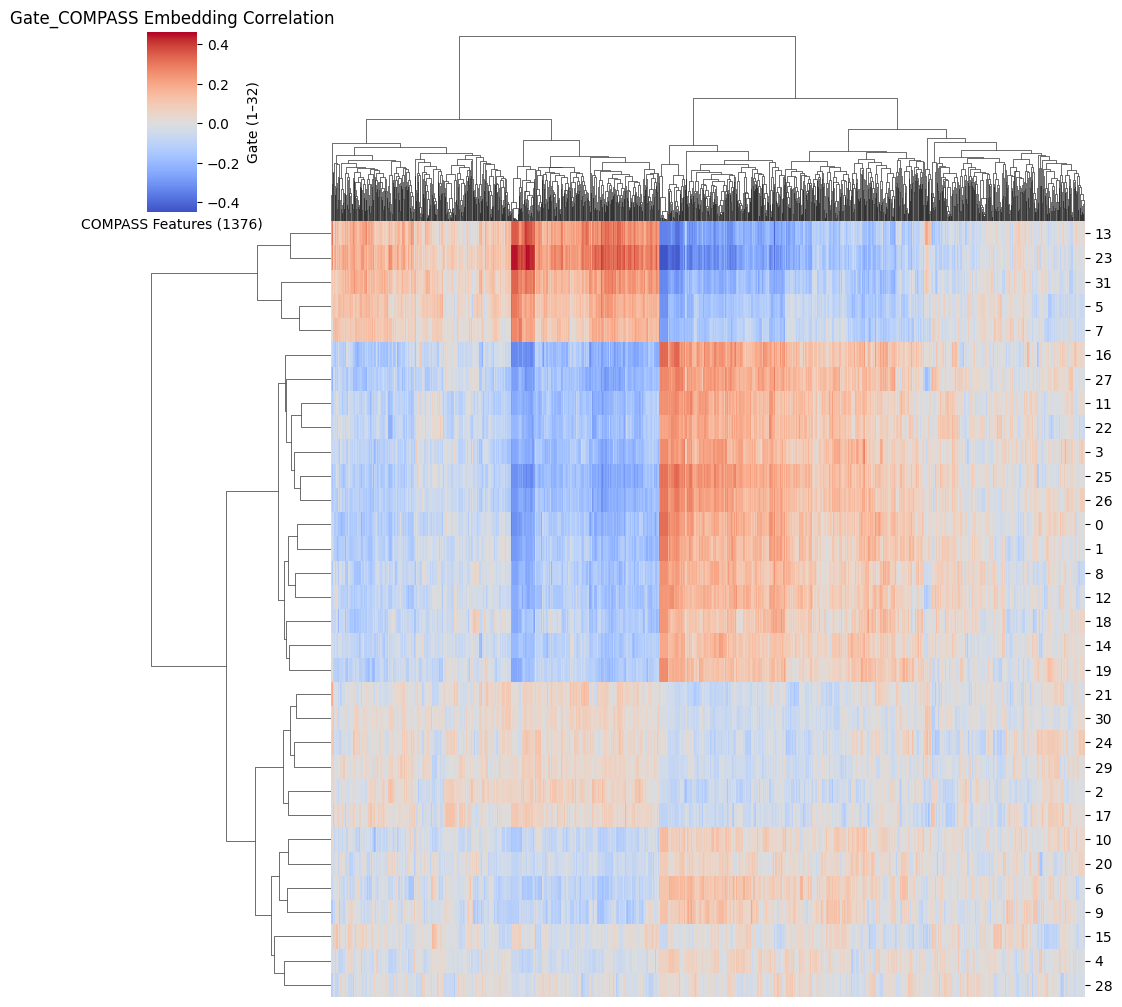

In [49]:

plt.figure(figsize=(18,10))
sns.clustermap(corr, cmap="coolwarm", center=0, xticklabels=False)
plt.xlabel("COMPASS Features (1376)")
plt.ylabel("Gate (1–32)")
plt.title("Gate_COMPASS Embedding Correlation")
plt.show()

In [50]:
corr_df = pd.DataFrame(corr,
                       index=[f"gate_{i}" for i in range(32)],
                       columns=compass_embedding.columns)

for g in range(32):
    print(f"Top COMPASS features associated with gate_{g}")
    print(corr_df.loc[f"gate_{g}"].abs().sort_values(ascending=False).head(5))
    print("\n")

Top COMPASS features associated with gate_0
channel_17_Immune_checkpoint    0.342754
channel_4_Immune_checkpoint     0.339132
channel_15_Immune_checkpoint    0.334035
channel_26_Immune_checkpoint    0.330344
channel_30_Memory_Bcell         0.329420
Name: gate_0, dtype: float64


Top COMPASS features associated with gate_1
channel_30_Memory_Bcell         0.307992
channel_4_Immune_checkpoint     0.302532
channel_15_Immune_checkpoint    0.302493
channel_17_Immune_checkpoint    0.301545
channel_26_Immune_checkpoint    0.299856
Name: gate_1, dtype: float64


Top COMPASS features associated with gate_2
channel_12_Platelet        0.177478
channel_17_Platelet        0.170498
channel_13_CD4_Tcell       0.162569
channel_19_Platelet        0.155550
channel_15_IFNg_pathway    0.154548
Name: gate_2, dtype: float64


Top COMPASS features associated with gate_3
channel_5_CD8_Tcell               0.289437
channel_4_cDC                     0.287057
channel_5_Cytotoxic_Tcell         0.280796
channel_8_Cy

In [51]:
corr_df.columns

Index(['channel_0_Adipocyte', 'channel_0_Apoptosis_pathway',
       'channel_0_Bcell_general', 'channel_0_CD4_Tcell', 'channel_0_CD8_Tcell',
       'channel_0_Cell_proliferation', 'channel_0_Cytokine',
       'channel_0_Cytotoxic_Tcell', 'channel_0_Endothelial',
       'channel_0_Epithelial',
       ...
       'channel_31_Pneumocyte', 'channel_31_Reference', 'channel_31_Stem',
       'channel_31_Stroma', 'channel_31_TGFb_pathway', 'channel_31_TLS',
       'channel_31_Tcell_general', 'channel_31_Treg', 'channel_31_cDC',
       'channel_31_pDC'],
      dtype='object', length=1376)

In [52]:
# deal with channel_0_ part 
def strip_channel_prefix(col):

    m = re.match(r"channel_(\d+)_(.+)", col)
    if m:
        return m.group(2)  
    else:
        return col

In [53]:
# delete more detail part 
def top_level_concept(stripped_name):
 
    return stripped_name.split("_")[0]

In [54]:


raw_cols = corr_df.columns


stripped = [strip_channel_prefix(c) for c in raw_cols]
families = [top_level_concept(s) for s in stripped]

concept_series = pd.Series(families, index=raw_cols, name="concepts_TIME")

unique_fams = concept_series.unique()
palette = sns.color_palette("tab20", n_colors=len(unique_fams))
fam_to_color = dict(zip(unique_fams, palette))


col_colors = concept_series.map(fam_to_color)

In [55]:
#stripped

/home/taiqili/.conda/envs/compass/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/taiqili/.conda/envs/compass/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


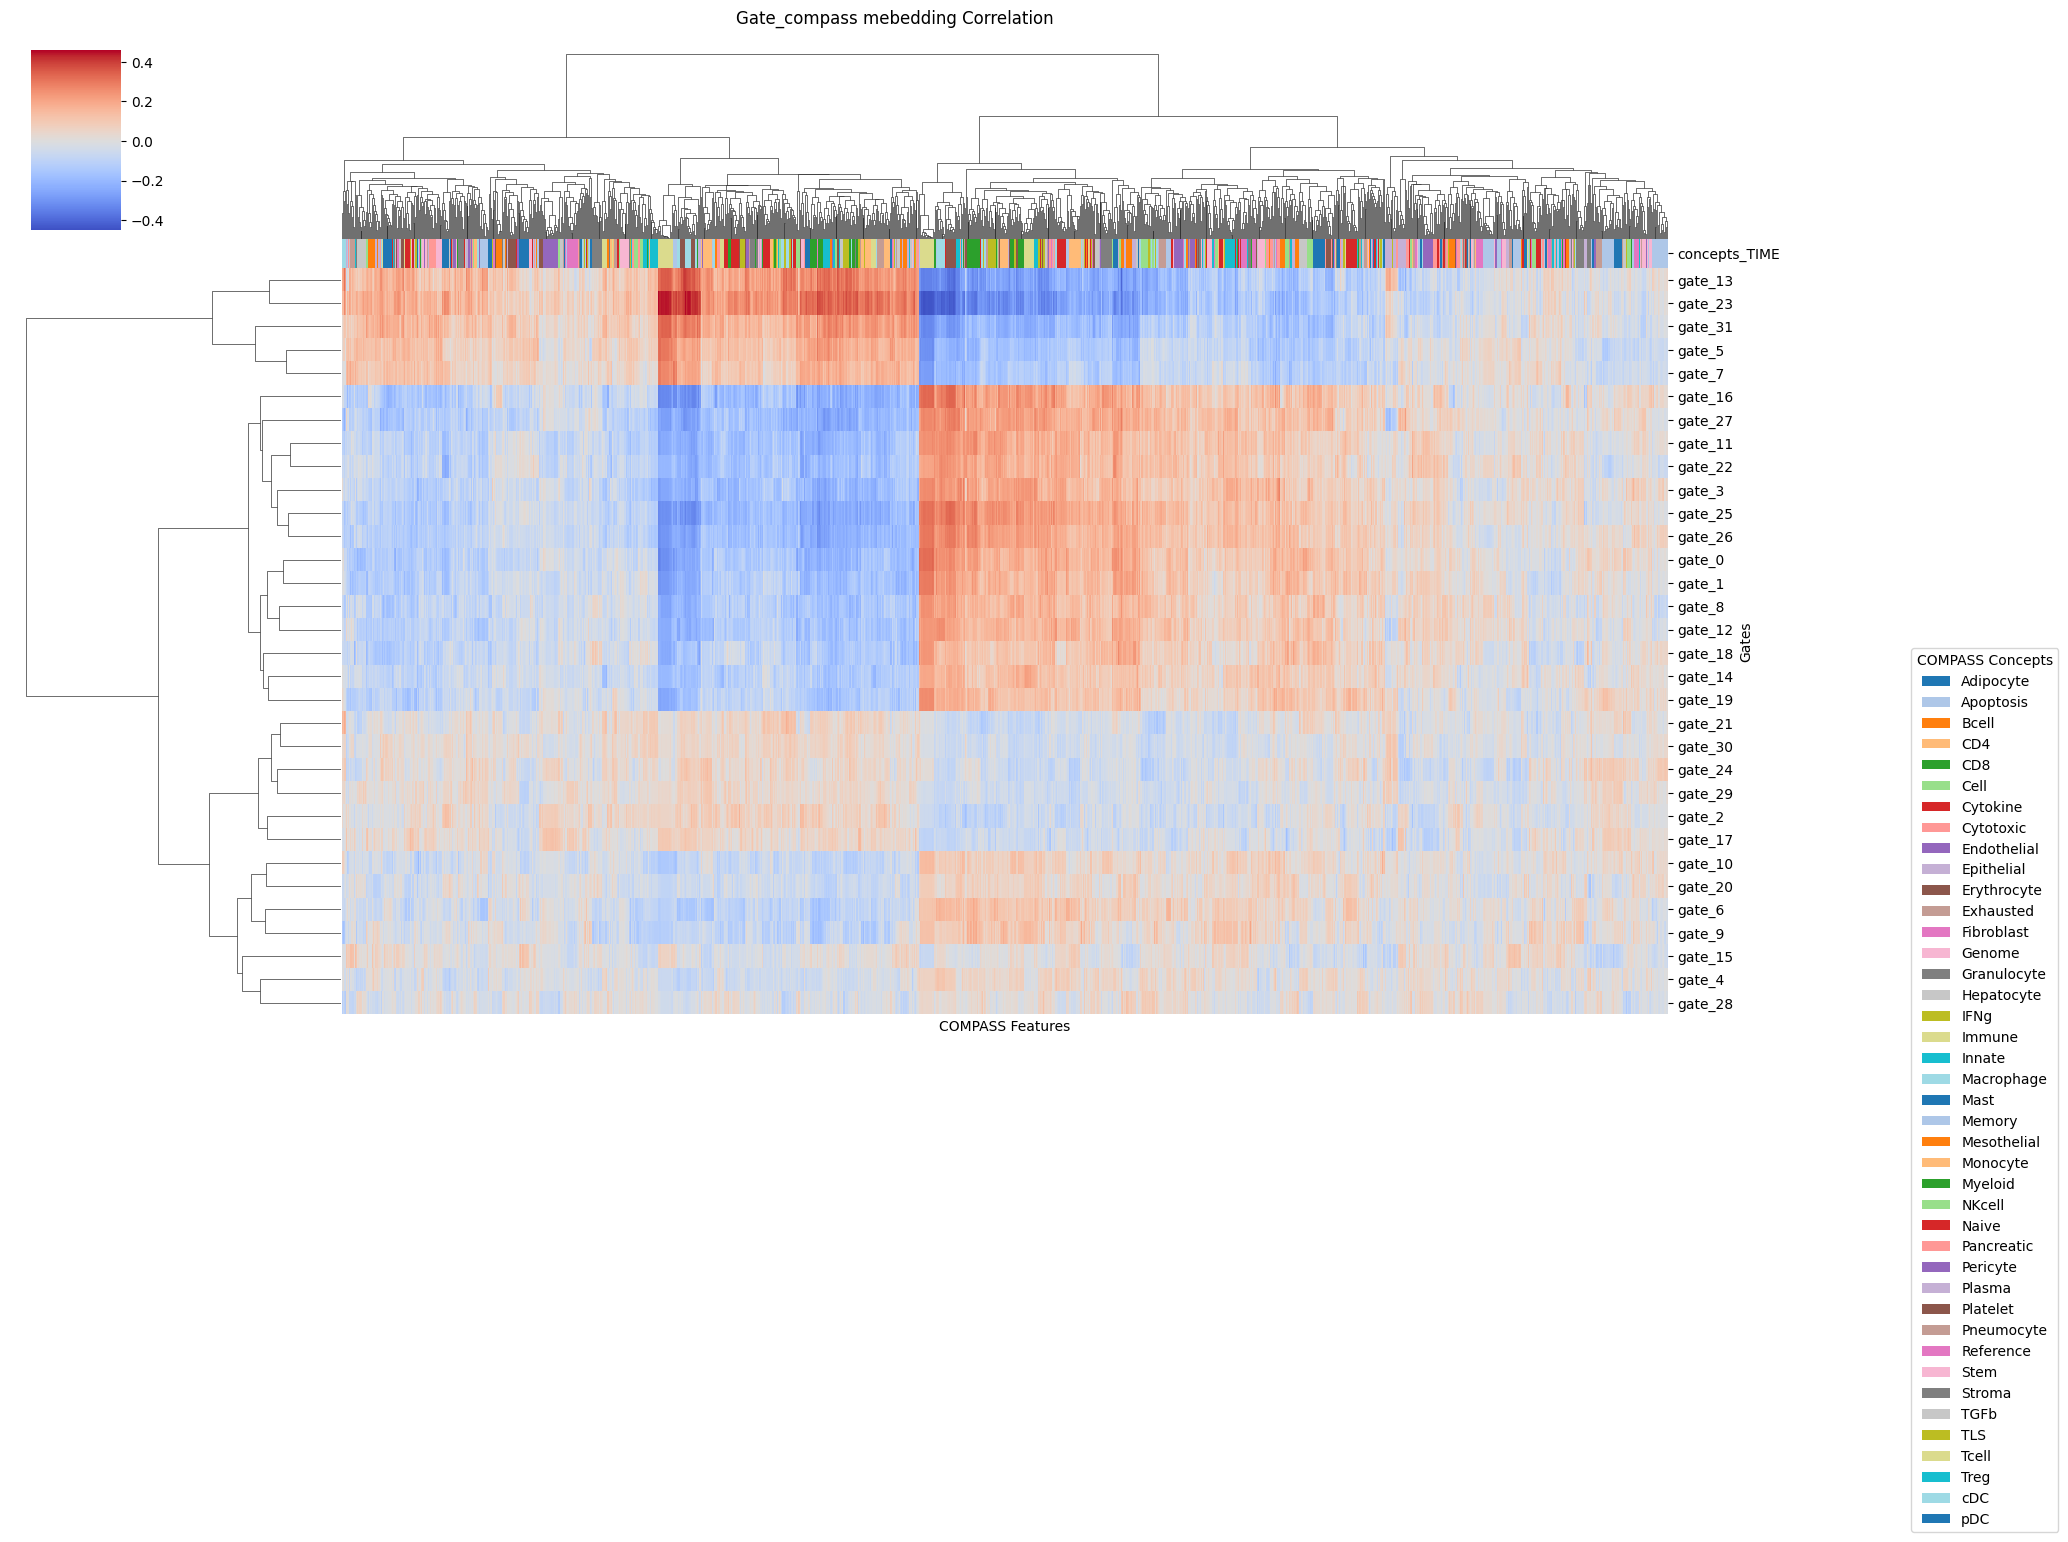

In [60]:
# cluster map for all gates
g = sns.clustermap(
    corr_df,
    cmap="coolwarm",
    center=0,
    row_cluster=True,
    col_cluster=True,
    col_colors=col_colors,  
    xticklabels=False,      
    yticklabels=True,
    figsize=(18, 10),
)

g.ax_heatmap.set_xlabel("COMPASS Features")
g.ax_heatmap.set_ylabel("Gates")

plt.suptitle("Gate_compass mebedding Correlation", y=1.02)



from matplotlib.patches import Patch

handles = [
    Patch(facecolor=fam_to_color[c], label=c)
    for c in unique_fams
]


g.ax_heatmap.legend(
    handles=handles,
    title="COMPASS Concepts",
    bbox_to_anchor=(1.3, 0.5),   
    bbox_transform=g.ax_heatmap.transAxes,
) 
plt.show()




In [61]:
abs(corr_df.loc['gate_31',:]).sort_values(ascending = False).to_csv('gate_31_decending.csv')

In [62]:
abs(corr_df.loc['gate_18',:]).sort_values(ascending = False).to_csv('gate_18_decending.csv')

In [105]:
max_abs_per_compass

channel_0_Adipocyte            0.324942
channel_0_Apoptosis_pathway    0.095735
channel_0_Bcell_general        0.194401
channel_0_CD4_Tcell            0.258284
channel_0_CD8_Tcell            0.277661
                                 ...   
channel_31_TLS                 0.261282
channel_31_Tcell_general       0.307854
channel_31_Treg                0.145062
channel_31_cDC                 0.461061
channel_31_pDC                 0.182544
Length: 1376, dtype: float64

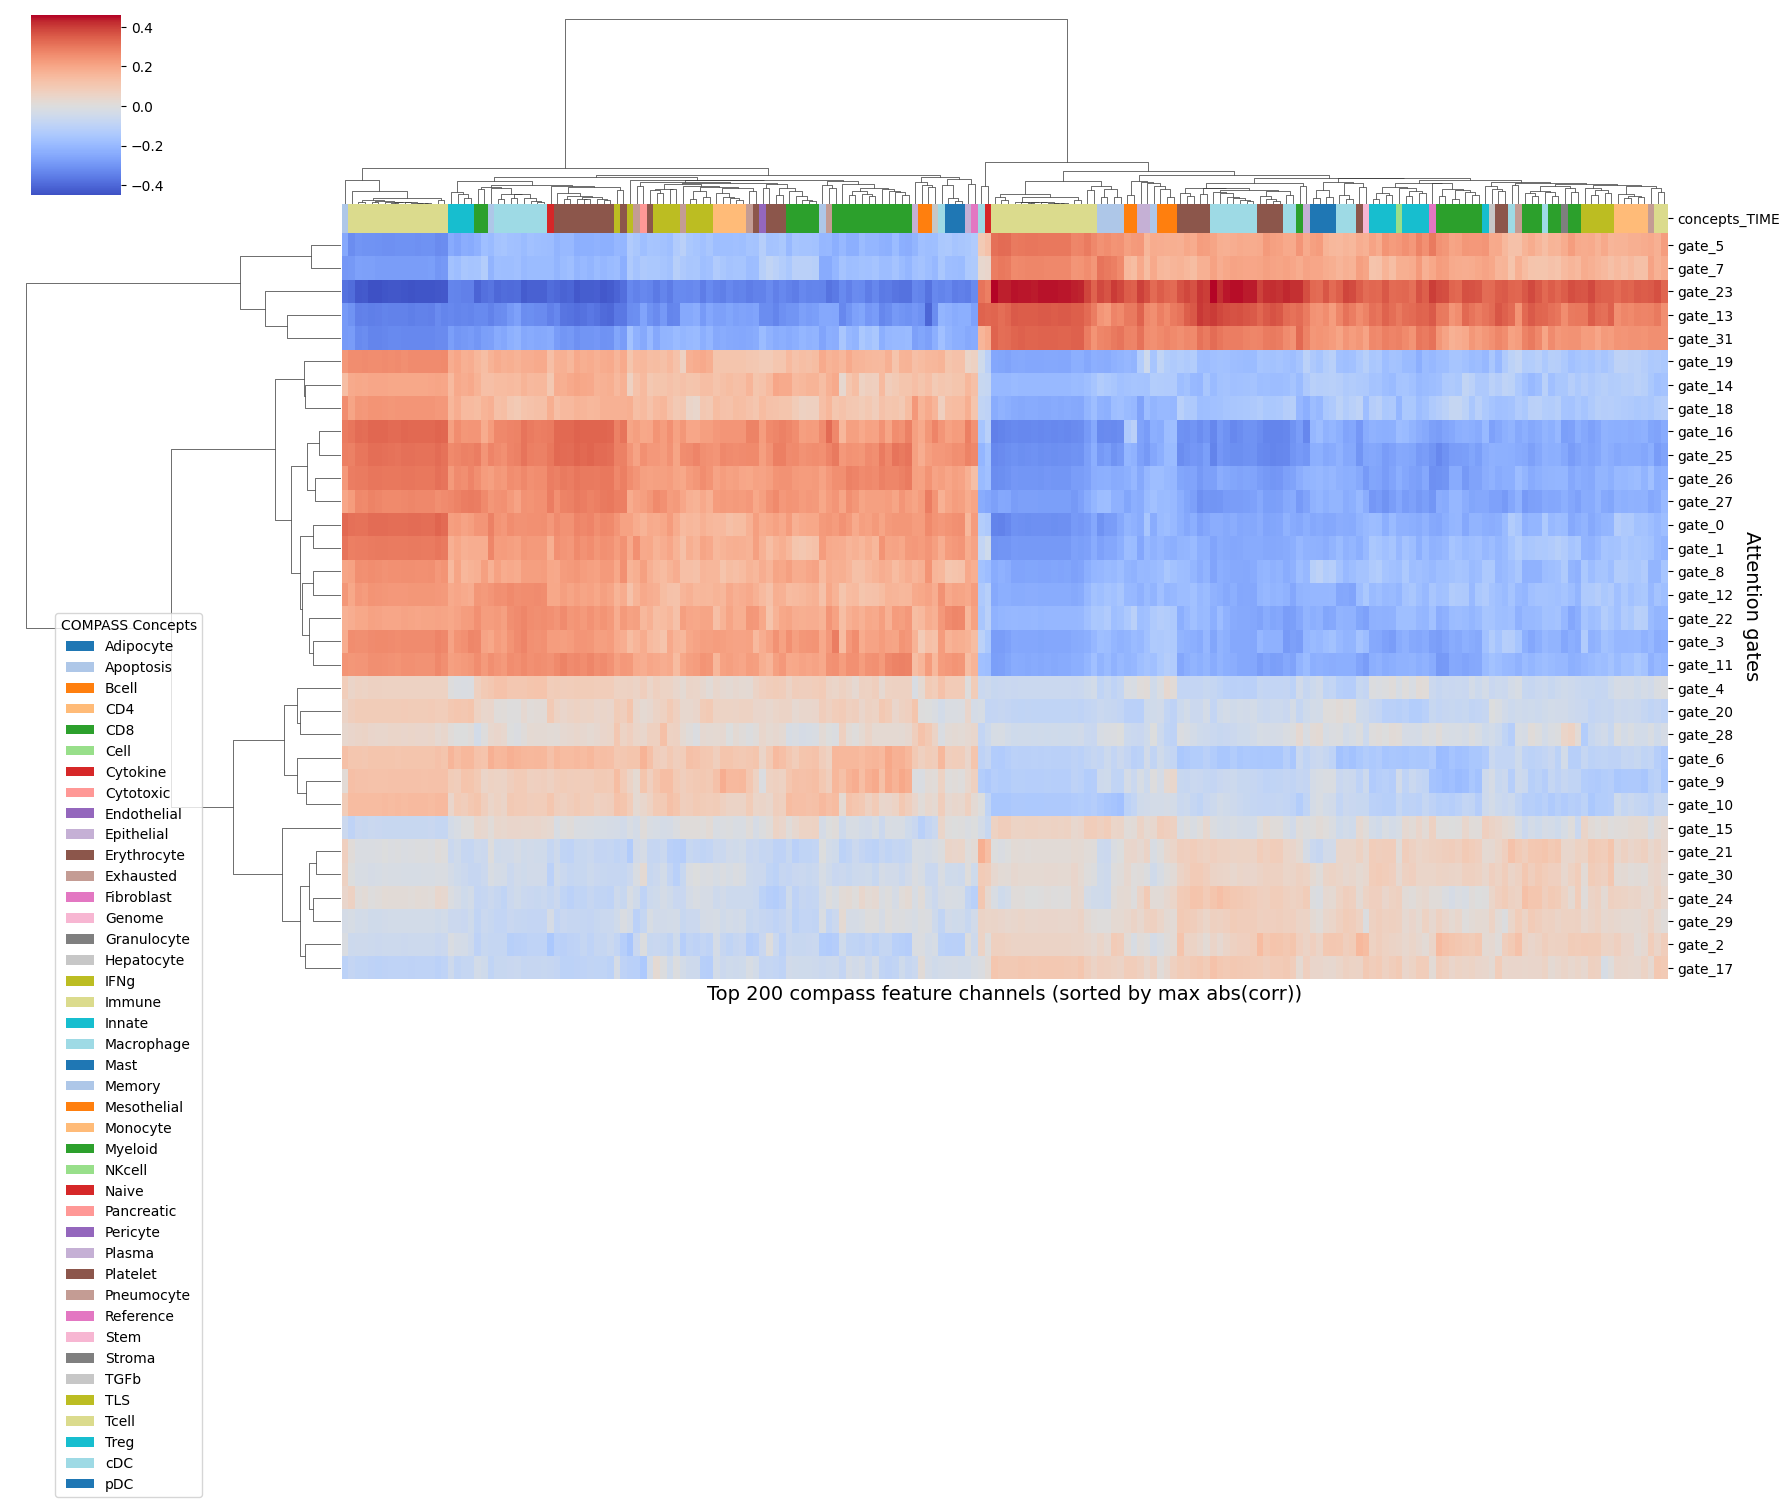

In [66]:
#max value per feature and choose the features have top 200 max corr values
max_abs_per_compass = corr_df.abs().max(axis=0)


top_compass = max_abs_per_compass.sort_values(ascending=False).head(200).index

corr_top = corr_df[top_compass]
concept_top = concept_series[top_compass]
col_colors_top = concept_top.map(fam_to_color)

g = sns.clustermap(
    corr_top,
    cmap="coolwarm",
    center=0,
    row_cluster=True,
    col_cluster=True,
    col_colors=col_colors_top,
    xticklabels=False,
    yticklabels=True,
    figsize=(18, 10)
)

g.ax_heatmap.set_xlabel("Top 200 compass feature channels (sorted by max abs(corr))", fontsize=14)
g.ax_heatmap.set_ylabel("Attention gates", fontsize=14, rotation= -90, labelpad=20)

handles = [
    Patch(facecolor=fam_to_color[c], label=c)
    for c in unique_fams
]


g.ax_heatmap.legend(
    handles=handles,
    title="COMPASS Concepts",
    bbox_to_anchor=(-0.1, 0.5),   
    bbox_transform=g.ax_heatmap.transAxes,
) 

plt.show()

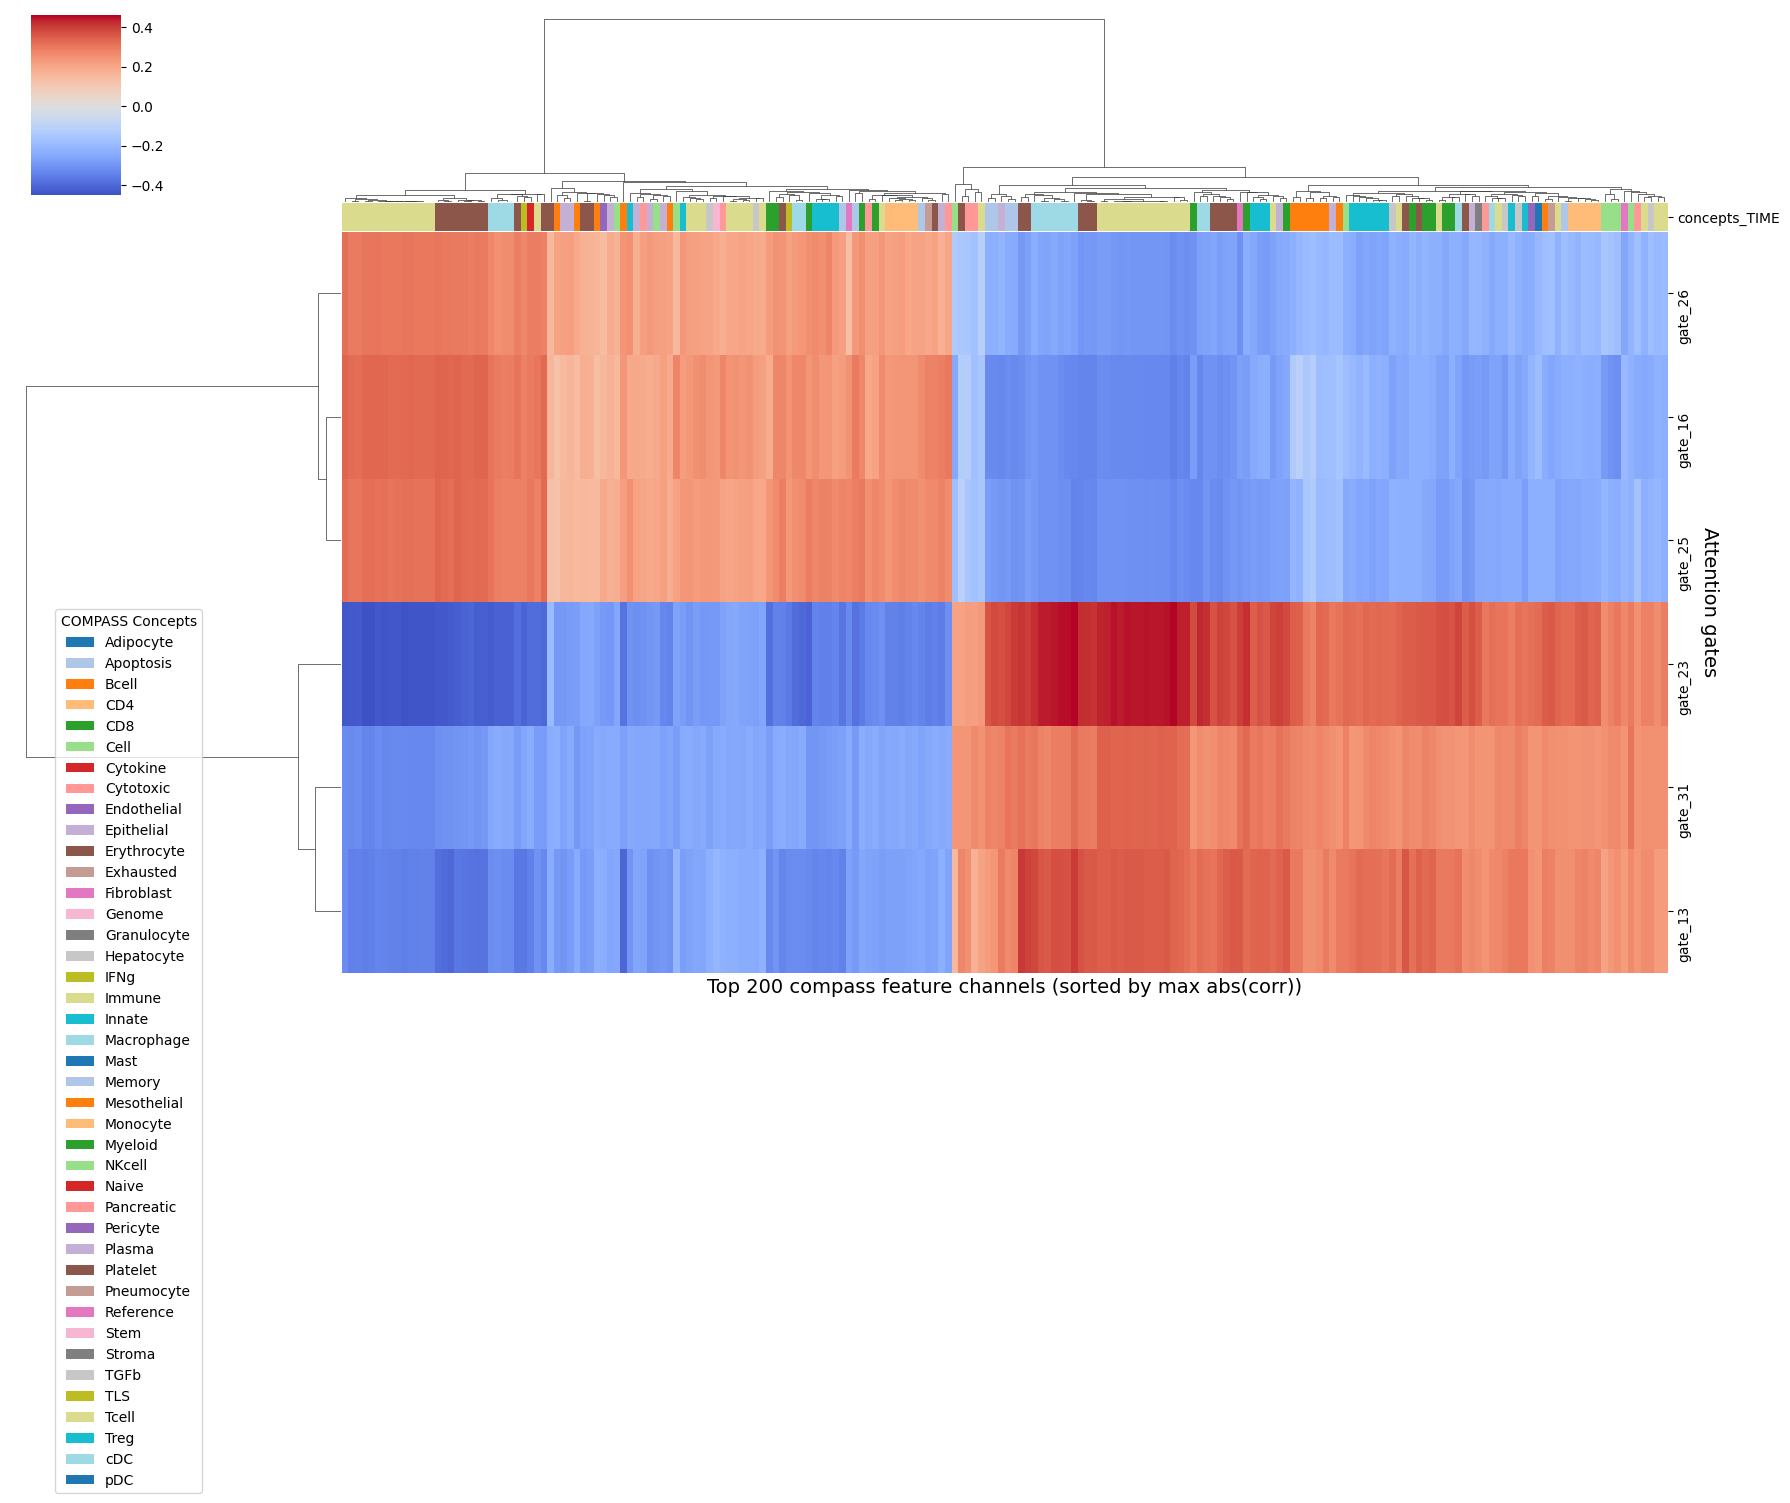

In [68]:
#max value per feature and choose the features have top 200 max corr values, for picked gate 
max_abs_per_compass = corr_df.loc[['gate_18','gate_31'],:].abs().max(axis=0)


top_compass = max_abs_per_compass.sort_values(ascending=False).head(200).index

corr_top = corr_df.loc[['gate_16','gate_25','gate_26','gate_31','gate_13','gate_23'],:][top_compass]
concept_top = concept_series[top_compass]
col_colors_top = concept_top.map(fam_to_color)

g = sns.clustermap(
    corr_top,
    cmap="coolwarm",
    center=0,
    row_cluster=True,
    col_cluster=True,
    col_colors=col_colors_top,
    xticklabels=False,
    yticklabels=True,
    figsize=(18, 10)
)

g.ax_heatmap.set_xlabel("Top 200 compass feature channels (sorted by max abs(corr))", fontsize=14)
g.ax_heatmap.set_ylabel("Attention gates", fontsize=14, rotation= -90, labelpad=20)

handles = [
    Patch(facecolor=fam_to_color[c], label=c)
    for c in unique_fams
]


g.ax_heatmap.legend(
    handles=handles,
    title="COMPASS Concepts",
    bbox_to_anchor=(-0.1, 0.5),   
    bbox_transform=g.ax_heatmap.transAxes,
) 

plt.show()

In [155]:
df_patient_final

,patient_id,risk,time,censor,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,...,gate_22,gate_23,gate_24,gate_25,gate_26,gate_27,gate_28,gate_29,gate_30,gate_31
0,TCGA-06-0125,2.692275,1448.0,1.0,0.495315,0.493830,0.500166,0.591093,0.433275,0.390575,...,0.492722,0.671014,0.702154,0.618236,0.342579,0.129594,0.152962,0.486722,0.768803,0.507655
1,TCGA-06-0129,1.081837,1024.0,1.0,0.523708,0.525204,0.498294,0.532797,0.431806,0.371275,...,0.432411,0.555753,0.604532,0.557718,0.467144,0.395409,0.416514,0.496293,0.576695,0.505292
2,TCGA-06-0130,0.967569,394.0,1.0,0.463555,0.595097,0.502029,0.572410,0.496213,0.412901,...,0.451467,0.657187,0.604742,0.551263,0.337864,0.271617,0.278938,0.492362,0.682725,0.503708
3,TCGA-06-0138,1.483634,737.0,1.0,0.506022,0.524540,0.497201,0.609354,0.531016,0.411617,...,0.378972,0.497870,0.501647,0.637350,0.570122,0.498751,0.463758,0.500440,0.497663,0.501960
4,TCGA-06-0141,2.171426,313.0,1.0,0.498133,0.460917,0.379953,0.318815,0.441756,0.376734,...,0.505488,0.499065,0.769975,0.506253,0.495494,0.492936,0.469250,0.505249,0.499938,0.501205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,TCGA-VM-A8CE,-2.563960,1191.0,0.0,0.740907,0.871887,0.496162,0.493379,0.670875,0.476916,...,0.564334,0.399176,0.499159,0.511913,0.252714,0.494883,0.606994,0.496599,0.508252,0.493390
453,TCGA-VV-A829,-0.785808,1127.0,0.0,0.531393,0.528280,0.498332,0.509663,0.496633,0.428000,...,0.491713,0.506459,0.543482,0.543217,0.506787,0.496828,0.484410,0.498757,0.498391,0.498423
454,TCGA-VV-A86M,-0.827852,487.0,0.0,0.626086,0.563663,0.446752,0.506144,0.471628,0.389043,...,0.481669,0.387893,0.570269,0.632174,0.533133,0.497414,0.466008,0.499661,0.500420,0.495948
455,TCGA-W9-A837,-2.626641,1553.0,0.0,0.564577,0.745267,0.429099,0.576843,0.477825,0.292658,...,0.538080,0.274299,0.647483,0.715462,0.705743,0.492817,0.592708,0.497632,0.568577,0.488797
